In [2]:
import json
import uuid
import IPython.display
import boto3
import s3fs
import rasterio
import xarray as xr
import rioxarray
import geojson
import pygeoif
import geopandas as gpd
import pandas as pd
import shapely.geometry
import hvplot.pandas  # noqa: F401
import matplotlib.pyplot as plt

from pystac_client import Client
from typing import Any, Dict
from pystac.item import Item
from shapely.geometry import shape
from IPython.display import display_html, display_javascript
from copy import deepcopy

# Calculating Coverage Percentage of the AOI by an Item

In [3]:
def intersection_percent(item: Item, aoi: Dict[str, Any]) -> float:
    """The percentage that the Item's geometry intersects the AOI. An Item that
    completely covers the AOI has a value of 100.
    """
    geom_item = shape(item.geometry)
    geom_aoi = shape(aoi)

    intersected_geom = geom_aoi.intersection(geom_item)

    intersection_percent = (intersected_geom.area * 100) / geom_aoi.area

    return intersection_percent

In [4]:
# geometry of the AOI to search over
intersects_geometry = {
    "type": "Polygon",
    "coordinates": [
        [
            [-73.21, 43.99],
            [-73.21, 47.05],
            [-70.12, 47.05],
            [-70.12, 43.99],
            [-73.21, 43.99],
        ]
    ],
}

In [5]:
# STAC API root URL
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Create a Client and an ItemSearch representing our search
# No search operations will be performed until we call the items() method
client = Client.open(URL)

item_search = client.search(
    collections=["sentinel-2-l2a"], intersects=intersects_geometry, max_items=100
)

In [6]:
print(
    [
        f"{intersection_percent(item, intersects_geometry):.2f}"
        for item in item_search.items()
    ]
)

['0.39', '1.91', '1.69', '1.48', '0.35', '3.09', '14.93', '14.69', '14.47', '3.58', '3.59', '14.91', '14.67', '14.44', '3.15', '1.21', '7.23', '9.20', '8.94', '2.11', '0.77', '1.24', '2.64', '9.19', '5.70', '2.28', '0.08', '2.14', '9.83', '9.37', '8.84', '1.89', '0.29', '1.88', '1.69', '1.48', '0.35', '2.80', '6.29', '9.70', '2.94', '0.25', '0.39', '1.91', '1.69', '1.48', '0.35', '3.09', '14.93', '14.69', '14.47', '3.58', '3.59', '14.91', '14.67', '14.44', '3.15', '1.22', '7.26', '9.21', '8.94', '2.11', '0.76', '1.22', '2.63', '9.17', '5.67', '2.26', '0.08', '2.14', '9.83', '9.37', '8.84', '1.88', '0.29', '1.87', '1.69', '1.48', '0.35', '2.78', '6.27', '9.68', '2.93', '0.25', '0.39', '1.91', '1.69', '1.48', '0.35', '3.09', '14.93', '14.69', '14.47', '3.58', '3.59', '14.91', '14.67', '14.44', '3.15', '1.21']


In [7]:
# create a generator that filters to only those Items that intersect more than 5%
items_gt_5_percent = (
    i for i in item_search.items() if intersection_percent(i, intersects_geometry) > 5
)

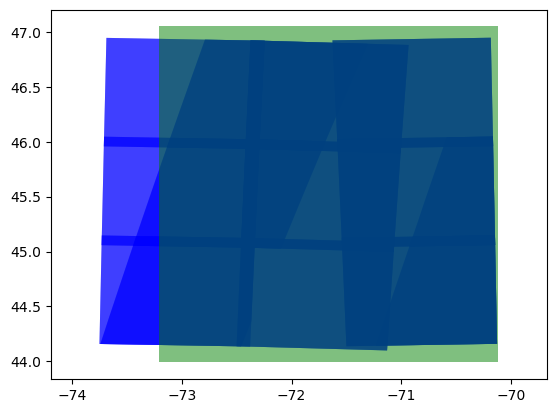

In [8]:
# Render the AOI and Item results
# The green shape is the AOI
# The blue shapes are the Item geometries
# If there are no blue shapes, adjust the intersection percent filter above
# until there are

cm = plt.get_cmap("RdBu")
fig, axs = plt.subplots()
axs.set_aspect("equal", "datalim")

for item in items_gt_5_percent:
    xs, ys = shape(item.geometry).exterior.xy
    axs.fill(xs, ys, alpha=0.5, fc="b", ec="none")

geom_intersects = shape(intersects_geometry)
xs, ys = geom_intersects.exterior.xy
axs.fill(xs, ys, alpha=0.5, fc="g", ec="none")

plt.show()